## Link my colab to my kaggle account

In [2]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8

import os

# Set up the correct path for kaggle.json in Windows
kaggle_path = os.path.join(os.path.expanduser('~'), '.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# Write your Kaggle credentials (username and API key) to kaggle.json
with open(os.path.join(kaggle_path, 'kaggle.json'), 'w') as f:
    f.write('{"username":"mahamat263","key":"f1ee9614acd621edd8fe8583f3c0f2e6"}')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73249 sha256=67ceef4e6cfe391cb076ce19e65fcc2e5198757c090cb9da5ad33a8584d1b606
  Stored in directory: /root/.cache/pip/wheels/b5/23/bd/d33cbf399584fa44fa049711892d333954a50ed4b86948109e
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.5
    Uninstalling kaggle-1.7.4.5:
      Successfully uninstalled kaggle-1.7.4.5


# Beijing Air Quality Forecasting Starter Notebook

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.layers import LSTM, Dense , Dropout , GRU ,LeakyReLU, BatchNormalization
import tensorflow as tf
from tensorflow.keras.regularizers import l2

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
# Set path to your Google Drive
drive_path = '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting'

# Load the datasets
!kaggle competitions download -c assignment-1-time-series-forecasting-may-2025 -p "{drive_path}"

# Unzip into the same directory
import zipfile

zip_path = os.path.join(drive_path, 'assignment-1-time-series-forecasting-may-2025.zip')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(drive_path)

# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/test.csv')


assignment-1-time-series-forecasting-may-2025.zip: Skipping, found more recently modified local copy (use --force to force download)


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [6]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [7]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [8]:
#check if the dataset have missing value
print('The Train dataset')
print(train.isnull().sum())

The Train dataset
No             0
DEWP           0
TEMP           0
PRES           0
Iws            0
Is             0
Ir             0
datetime       0
cbwd_NW        0
cbwd_SE        0
cbwd_cv        0
pm2.5       1921
dtype: int64


In [9]:
#check if the dataset have missing value
print('The Train dataset')
print(test.isnull().sum())

The Train dataset
No          0
DEWP        0
TEMP        0
PRES        0
Iws         0
Is          0
Ir          0
datetime    0
cbwd_NW     0
cbwd_SE     0
cbwd_cv     0
dtype: int64


In [10]:
train['pm2.5'].isnull().any()

np.True_

In [11]:
# Drop 24 rows where pm2.5
train = train.iloc[24:].reset_index(drop=True)

In [12]:
train['pm2.5'].isnull().sum()

np.int64(1897)

In [13]:
# Fill missing values (first forward, then backward to catch early NaNs)
train.fillna(method='ffill', inplace=True)
train.fillna(method='bfill', inplace=True)

<ipython-input-13-1583a8e5c81f>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train.fillna(method='ffill', inplace=True)
<ipython-input-13-1583a8e5c81f>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train.fillna(method='bfill', inplace=True)


In [14]:
train['pm2.5'].isnull().sum()

np.int64(0)

# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [15]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

In [16]:
# === Preprocessing Function ===
def preprocess(train):
    train = train.interpolate(method='time')
    train['hour'] = train.index.hour
    train['dayofweek'] = train.index.dayofweek
    train['month'] = train.index.month
    return train

train= preprocess(train)
test = preprocess(test)

In [17]:
# Separate features and target in training data
X_train_raw = train.drop(columns=['pm2.5', 'No'])
y_train = train['pm2.5']


In [62]:
# === Fit scaler only on training data ===
from sklearn.preprocessing import StandardScaler

# 2. Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(test[X_train_raw.columns])
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))

In [63]:
def create_sequences(data, target=None, seq_len=24):
    X, y = [], []
    for i in range(seq_len, len(data) + 1):  # include the last sequence
        X.append(data[i - seq_len:i])
        if target is not None:
            y.append(target[i - 1])  # Use i-1 to stay within bounds
    return np.array(X), np.array(y) if target is not None else None

In [64]:
# Generate sequences
sequence_length = 24
# Pad with zeros at the start (shape: (seq_len-1, features))
pad = np.zeros((sequence_length - 1, X_test_scaled.shape[1]))

# Concatenate padded data with the original scaled test data
X_test_padded = np.vstack([pad, X_test_scaled])

In [65]:
X_train_seq, y_train_seq = create_sequences(X_train_scaled, target=y_train_scaled, seq_len=sequence_length)
X_test_seq, _ = create_sequences(X_test_padded, target=None, seq_len=sequence_length)

In [22]:
X_test_seq.shape

(13148, 24, 12)

In [ ]:
# Split based on time — e.g., 80% train, 20% validation
split_index = int(len(train) * 0.8)

X_raw = train.drop(['pm2.5', 'No'], axis=1)
y = train['pm2.5']

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [23]:
# Define custom RMSE metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [142]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    # First GRU layer with return_sequences=True to feed the next GRU layer
    LSTM(16, return_sequences=True, activation='relu', kernel_regularizer=l2(1e-3), input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),

    # Second GRU layer, outputs sequence reduced, no return_sequences
    LSTM(8, kernel_regularizer=l2(1e-3), activation='relu'),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    # Final dense layer for regression output
    Dense(1)
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [143]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[rmse]
)

# Display model architecture
model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 24, 16)         │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_36 (LeakyReLU)      │ (None, 24, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 24, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_37 (LeakyReLU)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,665 (10.41 KB)

 Trainable params: 2,665 (10.41 KB)

 Non-trainable params: 0 (0.00 B)

In [144]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.7726 - rmse: 0.8302 - val_loss: 0.8688 - val_rmse: 0.7181
Epoch 2/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.5632 - rmse: 0.7092 - val_loss: 0.8155 - val_rmse: 0.6895
Epoch 3/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.5224 - rmse: 0.6790 - val_loss: 0.7293 - val_rmse: 0.6805
Epoch 4/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.4935 - rmse: 0.6641 - val_loss: 0.8119 - val_rmse: 0.6884
Epoch 5/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.4705 - rmse: 0.6493 - val_loss: 0.7807 - val_rmse: 0.6832
Epoch 6/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.4610 - rmse: 0.6344 - val_loss: 0.8567 - val_rmse: 0.6947
Epoch 7/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.4427 - rmse: 0.6281 - val_loss: 0.7579 - val_rmse: 0.6799
Epoch 8/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.4330 - rmse: 0.6182 - val_loss: 0.7824 - val_rmse: 0.7004
Epoch 9/100
766/766 ━━━━━

958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


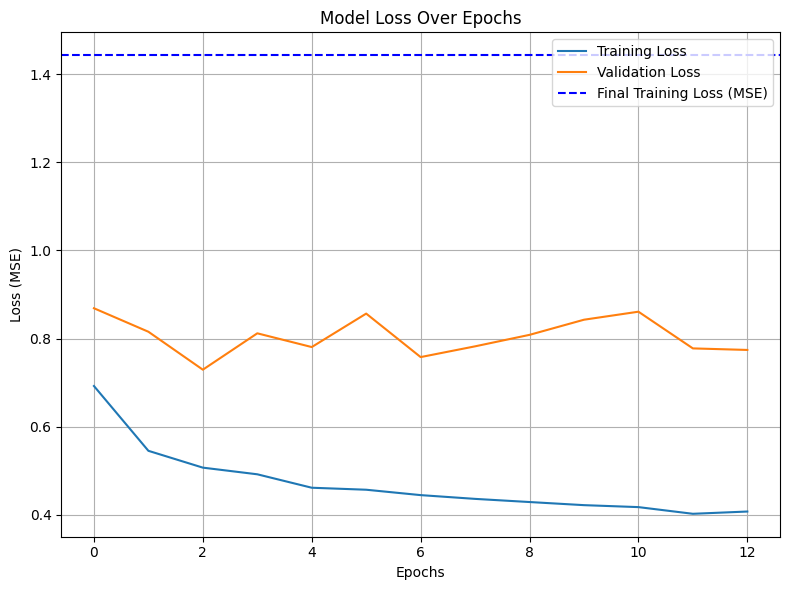

Final Training Loss (MSE): 1.4433


In [145]:
train_predictions = model.predict(X_train_seq)
train_loss = np.mean((y_train_seq - train_predictions.flatten())**2)

# Plot training and validation loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')

plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final Training Loss (MSE)')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Final Training Loss (MSE): {train_loss:.4f}")

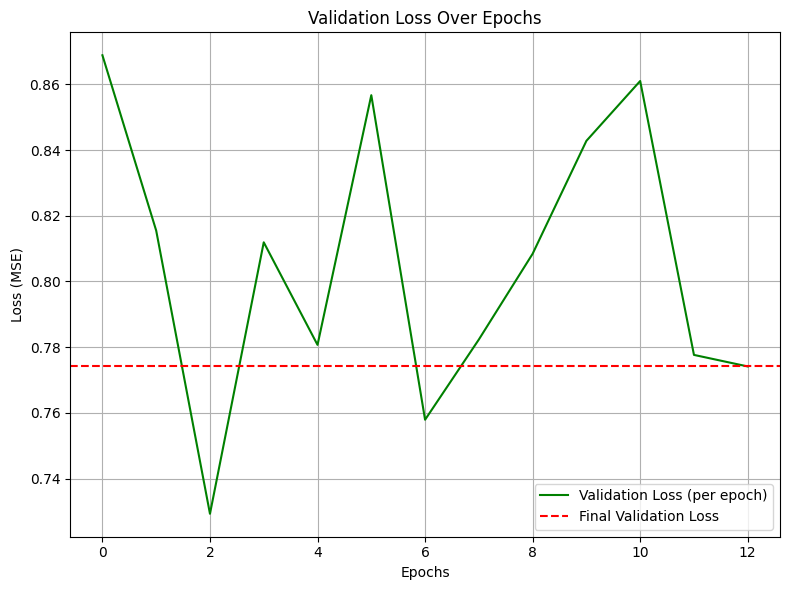

✅ Final Validation Loss (MSE): 0.7741


In [146]:
import matplotlib.pyplot as plt
import numpy as np

# Optional: Recalculate final validation loss (if not already done)
# Use the last value in history if `val_loss` was tracked
if 'val_loss' in history.history:
    val_loss = history.history['val_loss'][-1]
else:
    val_loss = None  # fallback in case validation wasn't used

# Plot Validation Loss over epochs
plt.figure(figsize=(8, 6))

if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss (per epoch)', color='green')
    plt.axhline(y=val_loss, color='red', linestyle='--', label='Final Validation Loss')
    plt.title('Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print(f"✅ Final Validation Loss (MSE): {val_loss:.4f}")
else:
    print("⚠️ Validation loss not available. Make sure you used `validation_split` or provided validation data.")

In [147]:
# Predict pm2.5 using the trained model
predictions = model.predict(X_test_seq)

# Inverse transform if target was scaled
predictions = scaler.inverse_transform(predictions)

# Handle NaNs if any (can happen rarely)
predictions = np.nan_to_num(predictions)

411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [148]:
# Remove first sequence_length rows from the test index to align with predictions
# Align with number of predictions
row_ids = pd.to_datetime(test.index[-len(predictions):]).strftime('%Y-%m-%d %-H:%M:%S')

submission = pd.DataFrame({
    'row ID': row_ids,
    'pm2.5': predictions.flatten()
})

submission = submission.sort_values(by='row ID')

submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/sample_submission.csv', index=False)

In [149]:
!kaggle competitions submit -c assignment-1-time-series-forecasting-may-2025 -f /content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/sample_submission.csv -m "Test submission"

100% 375k/375k [00:01<00:00, 259kB/s]
Successfully submitted to Assignment 1- Time Series Forecasting May 2025